# Rasterio

## Intro
Rasterio is the main library to work with raster data on python.
It has two levels of data structures:
- 1: datasets
- 2: arrays

Datasets holds all the geospatial attributes such as crs (coordinate system), transform (affine), bounds and bands.
Arrays are just numpy arrays

For this tutorial we will use a CBERS-4a image. It can be downloaded in http://www2.dgi.inpe.br/catalogo/explore

## Main goals
- Merge RGB bands, clip and reproject a CBERS image
- Plot the results and intermediate steps

## Summary
- filter
- numpy exchange

## References
https://rasterio.readthedocs.io/en/stable/quickstart.html

# Setup

In [1]:
import rasterio as rio
from rasterio.plot import show

from shapely.geometry import box
import geopandas as gpd

import numpy as np

from matplotlib import pyplot as plt

# Open Dataset

In [2]:
dataset = rio.open('../data/raster/CBERS/CBERS_4A_WPM_RGB_clip.tif')

# Dataset attributes

In [3]:
dataset.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2386, 'height': 2201, 'count': 3, 'crs': CRS.from_epsg(32723), 'transform': Affine(8.0, 0.0, 169834.0,
       0.0, -8.0, 7374654.0), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}

In [4]:
dataset.name

'../data/raster/CBERS/CBERS_4A_WPM_RGB_clip.tif'

In [5]:
dataset.mode

'r'

In [6]:
print(dataset.width)
print(dataset.height)

2386
2201


## Bands

In [7]:
dataset.count

3

In [8]:
dataset.indexes

(1, 2, 3)

In [9]:
# show the dtype for each bands
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}

{1: 'float32', 2: 'float32', 3: 'float32'}

## Coordinate system

In [10]:
dataset.crs

CRS.from_epsg(32723)

## Bounding box

In [11]:
# bounding box
dataset.bounds

BoundingBox(left=169834.0, bottom=7357046.0, right=188922.0, top=7374654.0)

In [12]:
#coordinates obtained by drawing on inpe platform: http://www2.dgi.inpe.br/catalogo/explore
bounding_box = box(-48.241546940324966,
                    -23.867859255764607,
                    -48.05064361935079,
                    -23.70523891895659)

In [13]:
# Save the boundbox as a shapefile can be usefull

# geom = box(*bounds)
# # Create a shapefile with GeoPandas

# df = gpd.GeoDataFrame({"id":1,"geometry":[geom]})
# df = df.set_crs(dataset.crs)
# df=df.to_crs('4326')
# df.to_file("..data/tmp/cbers_boundary.shp")

# In one line:

df = gpd.GeoDataFrame({"id":1,"geometry":[bounding_box]},crs='4326')
df.to_file("../data/tmp/cbers_boundary.shp")

## Transform Affine
A dataset’s DatasetReader.transform is an affine transformation matrix that maps pixel locations in (col, row) coordinates to (x, y) spatial positions. The product of this matrix and (0, 0), the column and row coordinates of the upper left corner of the dataset, is the spatial position of the upper left corner.

dataset.transform * (0, 0)
(358485.0, 4265115.0)
The position of the lower right corner is obtained similarly.

dataset.transform * (dataset.width, dataset.height)
(590415.0, 4028985.0)
But what do these numbers mean? 4028985 meters from where? These coordinate values are relative to the origin of the dataset’s coordinate reference system (CRS).

dataset.crs
CRS.from_epsg(32612)
EPSG:32612 identifies a particular coordinate reference system: UTM zone 12N. This system is used for mapping areas in the Northern Hemisphere between 108 and 114 degrees west. The upper left corner of the example dataset, (358485.0, 4265115.0), is 141.5 kilometers west of zone 12’s central meridian (111 degrees west) and 4265 kilometers north of the equator.

Between the DatasetReader.crs and DatasetReader.transform attributes, the georeferencing of a raster dataset is described and the dataset can compared to other GIS datasets.

In [14]:
dataset.transform

Affine(8.0, 0.0, 169834.0,
       0.0, -8.0, 7374654.0)

# Read 
When you use the read function it returns a numpy array

In [15]:
band1 = dataset.read(1)

In [16]:
type(band1)

numpy.ndarray

# Spatial indexes

In [17]:
# Datasets have an index() method for getting the array indices corresponding to points in georeferenced space.
# To get the value for the pixel 100 kilometers east and 50 kilometers south of the dataset’s upper left corner,
# do the following.

x, y = (dataset.bounds.left + 1000, dataset.bounds.top - 500)
row, col = dataset.index(x, y)
row, col
band1[row, col]

156.0

In [18]:
# To get the spatial coordinates of a pixel, use the dataset’s xy() method.
# The coordinates of the center of the image can be computed like this.

dataset.xy(dataset.height // 2, dataset.width // 2)

(179382.0, 7365850.0)

# No data

In [19]:
# https://rasterio.groups.io/g/main/topic/change_the_nodata_value_in_a/28801885
# convert 0 to nodata
# You need to open the source file to read data values and metadata,
# then read the band data as numpy array,
# make the required changes to the numpy array and then save numpay array to a new dataset file:

def fix_no_data_value(input_file, output_file, no_data_value=0):
    with rio.open(input_file, "r+") as src:
        src.nodata = no_data_value
        with rio.open(output_file, 'w',  **src.profile) as dst:
            for i in range(1, src.count + 1):
                band = src.read(i)
                band = np.where(band==no_data_value,no_data_value,band)
                dst.write(band,i)

# # usage example 
# input_file = "input_image.tif"
# output_file = "output.tif"
# no_data_value=0
# fix_no_data_value(input_file, output_file,no_data_value   )

# Merge bands into rgb image

In [20]:
# rescale image intensity before plotting.
def normalize(band):
    band_min, band_max = (np.nanmin(band), np.nanmax(band))
    return ((band - band_min))/((band_max - band_min))

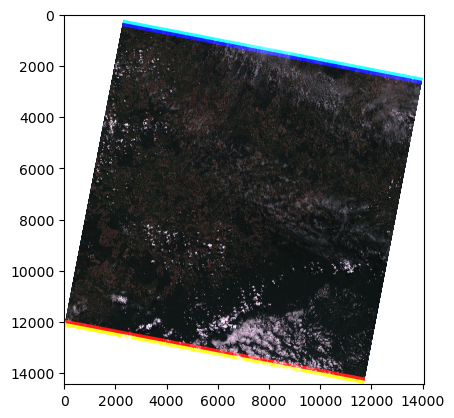

In [21]:
bands=[]
for b in ['../data/raster/CBERS/CBERS_4A_WPM_20230412_204_143_L2_BAND1.tif',
            '../data/raster/CBERS/CBERS_4A_WPM_20230412_204_143_L2_BAND2.tif',
            '../data/raster/CBERS/CBERS_4A_WPM_20230412_204_143_L2_BAND3.tif']:
    with rio.open(b) as file:
        img=file.read(1)
        img[img == img[0,0]] = np.nanmax(img) + 1
        bands.append((normalize(img)))

true_color = np.dstack([bands[2], bands[1], bands[0]])

plt.imshow(true_color)

In [52]:
true_color[:,:,0][true_color[:,:,0]<1]

array([0.07050645, 0.06951341, 0.0734856 , ..., 0.1082423 , 0.11817279,
       0.11519364])

In [53]:
bands[2][bands[2] <1 ]

array([0.07050645, 0.06951341, 0.0734856 , ..., 0.1082423 , 0.11817279,
       0.11519364])

In [22]:
band1=rio.open('../data/raster/CBERS/CBERS_4A_WPM_20230412_204_143_L2_BAND1.tif')
band2=rio.open('../data/raster/CBERS/CBERS_4A_WPM_20230412_204_143_L2_BAND2.tif')
band3=rio.open('../data/raster/CBERS/CBERS_4A_WPM_20230412_204_143_L2_BAND3.tif')


In [ ]:

band2_geo = band2.profile
band2_geo.update({"count": 3})

with rio.open('../data/raster/CBERS/rgb.tiff', 'w', **band2_geo) as dest:
    dest.write(band1.read(1),3) #blue band
    dest.write(band2.read(1),2) #green
    dest.write(band3.read(1),1) #red

In [21]:
from rasterio.merge import merge
merge(datasets=[rio.open('../data/raster/CBERS/CBERS_4A_WPM_20230412_204_143_L2_BAND3.tif'),
                rio.open('../data/raster/CBERS/CBERS_4A_WPM_20230412_204_143_L2_BAND2.tif'),
                 rio.open('../data/raster/CBERS/CBERS_4A_WPM_20230412_204_143_L2_BAND1.tif')],
        nodata=0)

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=int16),
 Affine(8.0, 0.0, 146154.0,
        0.0, -8.0, 7421262.0))

# Clip

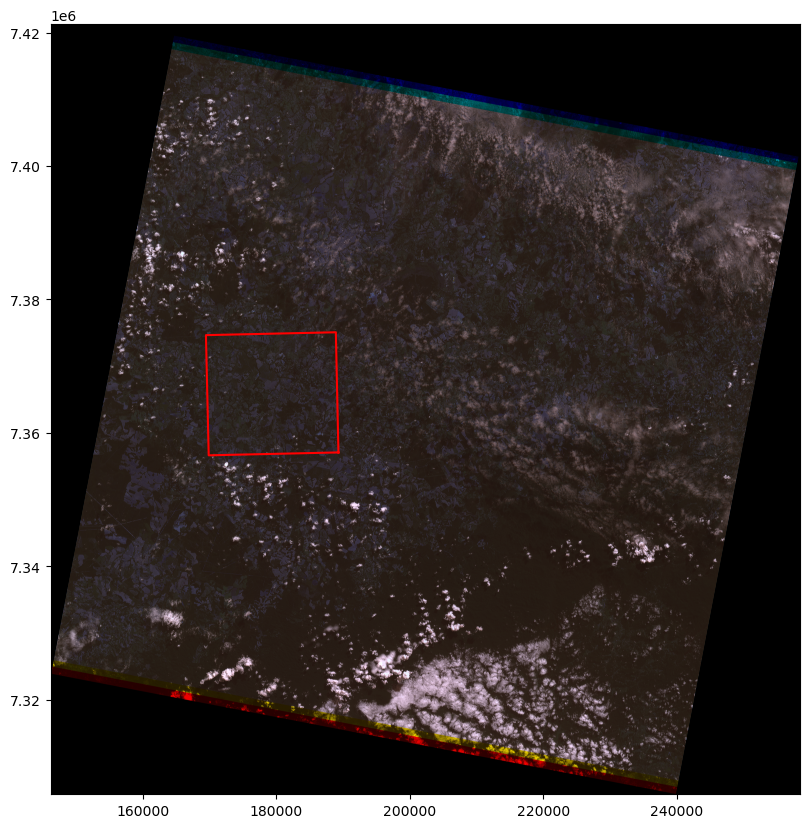

In [22]:
inshp = "../data/tmp/cbers_boundary.shp"
raster = rio.open('../data/raster/CBERS/rgb.tiff')
Vector=gpd.read_file(inshp).to_crs(raster.crs)
fig, ax = plt.subplots(1,1,figsize=(10,10))

show((raster, [3,2,1]), adjust=True, ax = ax)
ax=plt.plot(*Vector.geometry[0].exterior.xy, color='r')

In [51]:
from rasterio.mask import mask
import geopandas as gpd

inshp = "../data/tmp/cbers_boundary.shp"
inRas = '../data/raster/CBERS/rgb.tiff'
outRas = '../data/raster/CBERS/rgb_clip.tiff'

Vector=gpd.read_file(inshp)

with rio.open(inRas) as src:
    Vector=Vector.to_crs(src.crs)
    # print(Vector.crs)
    out_image, out_transform=mask(src,Vector.geometry,crop=True)
    out_meta=src.meta.copy() # copy the metadata of the source DEM
    
out_meta.update({
    "driver":"Gtiff",
    "height":out_image.shape[1], # height starts with shape[1]
    "width":out_image.shape[2], # width starts with shape[2]
    "transform":out_transform
})
              
with rio.open(outRas,'w',**out_meta) as dst:
    dst.write(out_image)

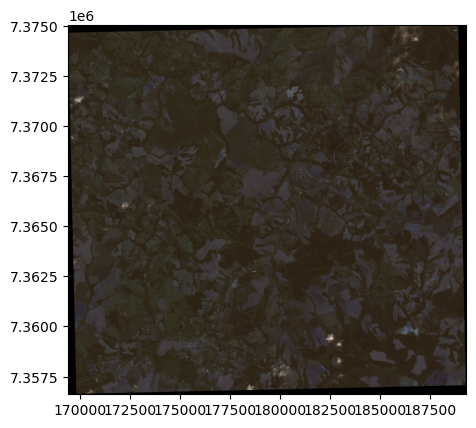

<Axes: >

In [56]:
img = rio.open('../data/raster/CBERS/rgb_clip.tiff')
show((img, [3,2,1]),adjust='linear')

# Reproject

In [59]:
#https://hatarilabs.com/ih-en/how-to-reproject-single-and-multiple-rasters-with-python-and-rasterio-tutorial
from rasterio.warp import calculate_default_transform, reproject, Resampling
#open source raster
srcRst = img
dstCrs = {'init': 'EPSG:4326'}

#calculate transform array and shape of reprojected raster
transform, width, height = calculate_default_transform(
        srcRst.crs, dstCrs, srcRst.width, srcRst.height, *srcRst.bounds)

kwargs = srcRst.meta.copy()
kwargs.update({
        'crs': dstCrs,
        'transform': transform,
        'width': width,
        'height': height
    })
#open destination raster
dstRst = rio.open('../data/raster/CBERS/rgb_clip_wgs84.tiff', 'w', **kwargs)
#reproject and save raster band data
for i in range(1, srcRst.count + 1):
    reproject(
        source=rio.band(srcRst, i),
        destination=rio.band(dstRst, i),
        #src_transform=srcRst.transform,
        src_crs=srcRst.crs,
        #dst_transform=transform,
        dst_crs=dstCrs,
        resampling=Resampling.nearest)
#close destination raster
dstRst.close()

# Plot

In [16]:
# https://rasterio.readthedocs.io/en/latest/topics/color.html
# GDAL builds the color interpretation based on the driver and creation options. With the GTiff driver, rasters with exactly 3 bands of uint8 type will be RGB, 4 bands of uint8 will be RGBA by default.

# Color interpretation can be set when creating a new datasource with the photometric creation option:

# profile = src.profile
# profile['photometric'] = "RGB"
# with rio.open("/tmp/rgb.tif", 'w', **profile) as dst:
#     dst.write(src.read())

# # or via the colorinterp property when a datasource is opened in update mode:

# from rasterio.enums import ColorInterp
# with rio.open('../data/raster/CBERS/rgb_clip_wgs84.tiff', 'r+', **profile) as src:
#     src.colorinterp = [
#         ColorInterp.red, ColorInterp.green, ColorInterp.blue]

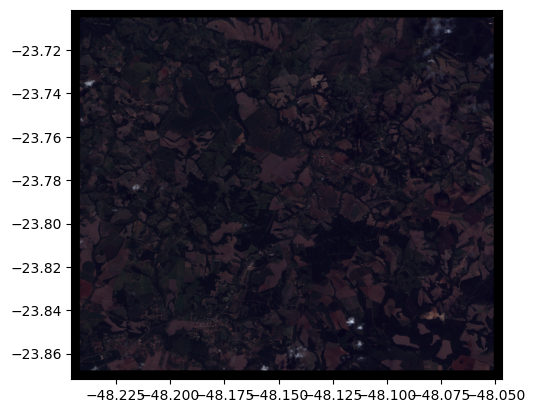

<Axes: >

In [36]:
img = rio.open('../data/raster/CBERS/rgb_clip_wgs84.tiff', 'r')
show((img,[3,2,1]), adjust=True)

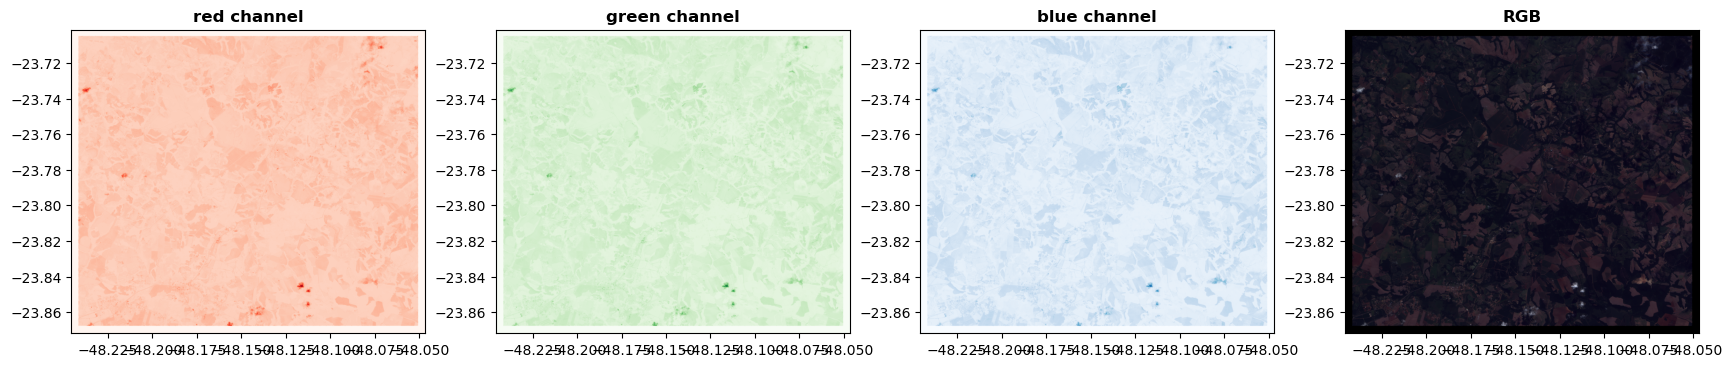

In [35]:
fig, (axr, axg, axb,axrgb) = plt.subplots(1,4, figsize=(21,10))
show((img, 3), ax=axr, cmap='Reds', title='red channel')
show((img, 2), ax=axg, cmap='Greens', title='green channel')
show((img, 1), ax=axb, cmap='Blues', title='blue channel')
show(img, ax=axrgb, title='RGB',adjust=True)

plt.show()

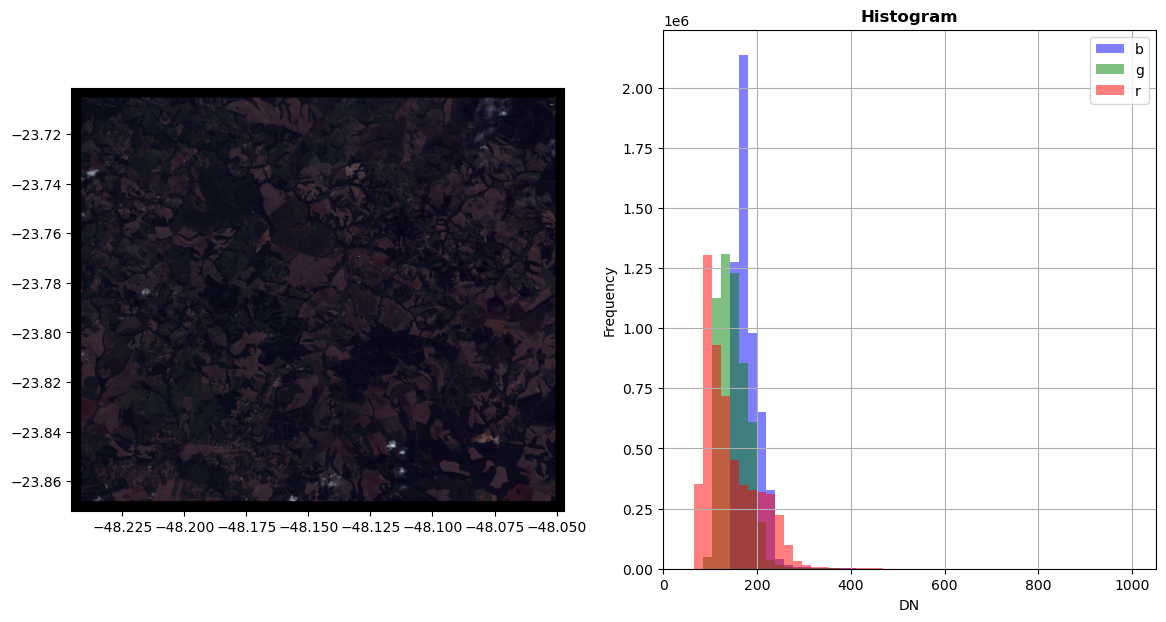

In [34]:
from rasterio.plot import show_hist
fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
show(img, ax=axrgb, adjust=True)
show_hist(img, bins=50, histtype='stepfilled',
          lw=0.0, stacked=False, alpha=0.5, ax=axhist,label=['r','g', 'b'])
plt.show()